In [1]:
from lrl_wiki_cls.wiki_text_cls_dataset import (
    WikiTextClsDataset,
    count_labels as get_dict_of_label_counts,
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lrl_wiki_cls.structure_category_metadata import (
    load_dataset_and_cat_metadata,
    get_and_plot_hierarchy_graph,
    print_dataset_overview
)
import numpy as np

dataset, cat_metadata = load_dataset_and_cat_metadata()

# A high-level overview of the dataset

In [2]:
# The text length is the number of characters in the text
print_dataset_overview(dataset)

Num. documents: 10065
Num. unique categories: 222

        Text Length  Num. Categories
count  10065.000000     10065.000000
mean     328.264580         4.811923
std     1189.219629         4.235034
min        6.000000         1.000000
25%       61.000000         2.000000
50%       79.000000         2.000000
75%      183.000000         8.000000
max    35180.000000        29.000000


# Exploring the structure of the category/subcategory network

## Visualizing the graph

Each edge in the graph is from a category to one of its subcategories.
Hence, the root node (which corresponds to the highest-level) is at the top of the plot.

Note that the root node does not correspond to a category, it was added to link all the top-level categories for the visualization.

Furthermore, the parent categories of each category associated with a document were collected and added to the set of labels for an article (See the example in the next section for further explanation).

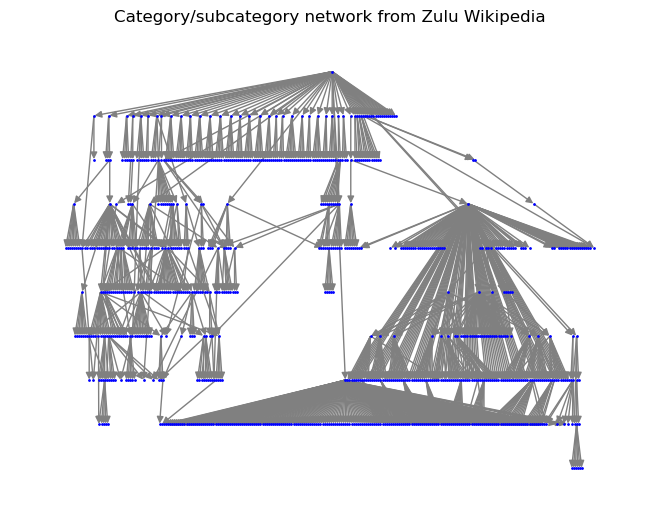

In [3]:
_ = get_and_plot_hierarchy_graph(dataset, cat_metadata)

## A concrete example

Below, we consider the labelling of the article '[Misuzulu Zulu](https://zu.wikipedia.org/wiki/Misuzulu_Zulu)' (which is about Misuzulu Zulu, the king of the Zulu nation as of 2021).

Note that the article was only explicitly categorized into the three categories shown in the screenshot below ("Abantu baphilayo" meaning "Living people", "Abazalwa nge-1974" meaning "Born in 1974", and "Amakhosi akwaZulu" meaning "Kings of Zululand"), but we collected the all the parent categories, and so in our dataset, this article is associated with more than just these three categories (the full list is shown after the next code cell).

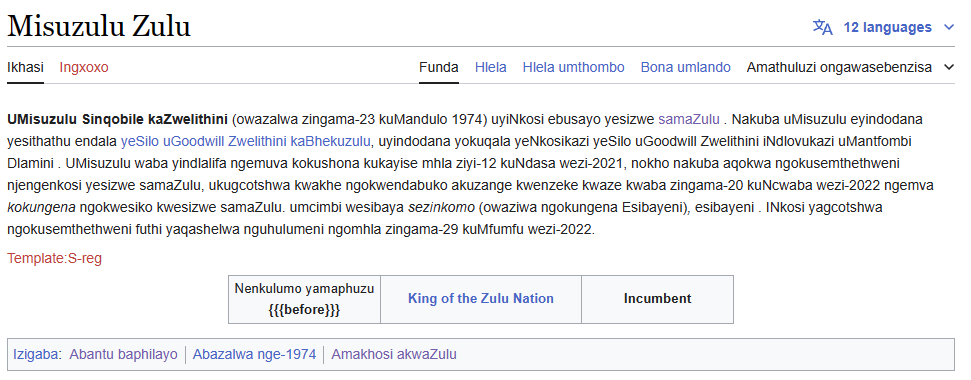

In [4]:
example_entry = None
for entry, categories in dataset:
    if entry["title"] == "Misuzulu Zulu":
        example_entry = entry
import json

print(json.dumps(example_entry["categories"], indent=4))

[
    "Amakhosi_akwaZulu",
    "Abantu_baphilayo",
    "1970s",
    "Ikhulu_leminyaka_engama-20",
    "Ikhulu_leminyaka",
    "Abazalwa_nge-1970s",
    "Iminyaka_eyishumi",
    "Iminyaka",
    "Izifanekiso_ezidinga_ukuhunyushwa_ku-isiZulu",
    "Amakhalenda",
    "Isikhathi",
    "AmaZulu"
]


For the rest of this example, we will focus on the categories "Abantu baphilayo" and "Amakhosi akwaZulu".

Neither of these categories is a subcategory of the other, and they are not mutually exclusive (this is evidenced by the fact that both categories are associated with the same article).

However, "Amakhosi akwaZulu" is a subcategory of "AmaZulu" (which means "The Zulus"), i.e. Zulu kings are Zulu.

In [5]:
for cat in example_entry["categories"]:
    if cat == "Abantu_baphilayo" or cat == "Amakhosi_akwaZulu" or cat == "AmaZulu":
        print(f"Subcategories of {cat}: {list(cat_metadata.get_subcats_of(cat))}")
        print(f"Supercategories of {cat}: {list(cat_metadata.get_supcats_of(cat))}")
        print()

Subcategories of Amakhosi_akwaZulu: ['Shaka']
Supercategories of Amakhosi_akwaZulu: ['AmaZulu']

Subcategories of Abantu_baphilayo: []
Supercategories of Abantu_baphilayo: []

Subcategories of AmaZulu: ['Abantu_amaZulu', 'Amakhosi_akwaZulu']
Supercategories of AmaZulu: []



This type of labelling is not possible in the formulation of hierarchical classification introduced by Silla and Freitas (2011).

The framework for hierarchical classification assumes that the classes can be organized into a hierarchy of levels that take on _one_ of a set of _mutually exclusive_ values.
In other words, hierarchical classification does not allow a single document to be associated with multiple classes from the same level.

In our example, the article is associated with at most two top-level classes, since 'Abantu_baphilayo' and 'AmaZulu' are both classes in the highest layer of the hierarchy.

**Reference:**

`Silla, C. and Freitas, A. (2011). A survey of hierarchical classification across
 different application domains. Data Mining and Knowledge Discovery, vol. 22,
 pp. 31–72.`

## Visualization of the frequency of occurence of each label 

In [6]:
def count_labels(dataset):
    assert isinstance(dataset, WikiTextClsDataset)
    assert isinstance(dataset.data, list)
    label_counts = get_dict_of_label_counts(dataset.data)
    count_df = pd.DataFrame(
        label_counts.items(), columns=["Category", "Num. docs associated with label"]
    )
    count_df = count_df.sort_values(by="Num. docs associated with label", ascending=False)
    return count_df, len(label_counts.keys())


def visualize_label_distribution(count_df, title="Label distribution"):
    sns.displot(
        count_df, x="Num. docs associated with label", kind="hist", kde=True, height=5, aspect=2
    )
    plt.title(title)
    plt.show()


count_df, num_unique_labels = count_labels(dataset)

Note that labels associated with fewer than 20 docs were removed during preprocessing.
The reason for this is that Gao et al. (2021) use 16 training examples per class for their few-shot scenario, therefore, assuming an 80/20 train/test split, we need at least 20 examples per class, since .8*20 = 16.

**Reference:**

[Making Pre-trained Language Models Better Few-shot Learners](https://aclanthology.org/2021.acl-long.295) (Gao et al., ACL-IJCNLP 2021)

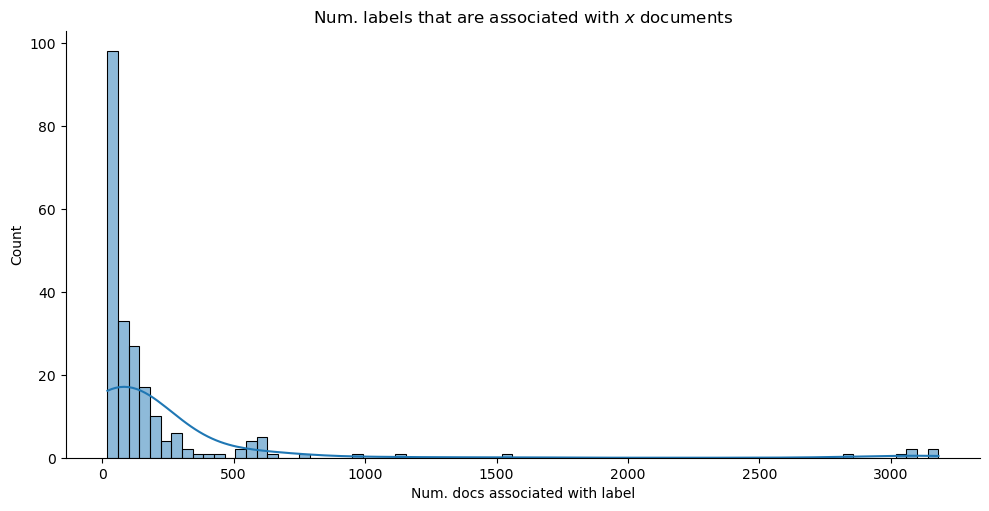

,Num. docs associated with label
count,222.000000
mean,218.162162
std,513.254377
min,20.000000
25%,35.000000
50%,79.500000
75%,158.500000
max,3181.000000


In [7]:
threshold = 20
# We already filtered the dataset during preprocessing/structuring.
assert min(count_df["Num. docs associated with label"]) == threshold
visualize_label_distribution(
    count_df,
    title=f"Num. labels that are associated with $x$ documents",
)
count_df.describe()

# Finding the most promising class hierarchy for a single hierarchy classification problem with a single

In [8]:
count_df.head(10)

,Category,Num. docs associated with label
0,Wikipedia,3181
4,Izihloko,3166
3,Amazwe,3073
11,Ezezwe,3070
10,Amazwekazi,3056
9,IAfrika,2848
8,Amazwe_e-Afrika,1539
89,I-Aljeriya,1147
105,I-Itiyopiya,974
197,Ama-Woreda_ase_Itiyopiya,760


In [9]:
cat = "Amazwe"
subcats = list(cat_metadata.get_subcats_of(cat))
print(f"Num. subcategories of {cat}: {len(subcats)}")
print(f"Subcategories of {cat}: {json.dumps(subcats, indent=4)}")
print(f"Supercategories of {cat}: {list(cat_metadata.get_supcats_of(cat))}")


Num. subcategories of Amazwe: 30
Subcategories of Amazwe: [
    "IsiSeyisheli",
    "ITshile",
    "ISpeyini",
    "Amazwe_OPEC",
    "I-Angola",
    "ISlovakiya",
    "Amazwe_e-Afrika",
    "IZimbabwe",
    "INingizimu_Afrika",
    "I-Itiyopiya",
    "IButswana",
    "Amazwe_ngolimi",
    "Amazwe_eYurophu",
    "Ezombusazwe_ngokwamazwe",
    "Venezuela",
    "IKolombiya",
    "IBenini",
    "IKrowati",
    "Izigaba_ngezwe",
    "Amazwe_e-Eshiya",
    "I-Ostreliya",
    "IViyetnami",
    "IYukreyini",
    "IShayina",
    "Amazwe_eYurophu_Empumalanga",
    "IBrazili",
    "ITheki",
    "INigeria",
    "Amazwe_G15",
    "IThailande"
]
Supercategories of Amazwe: ['Izihloko']


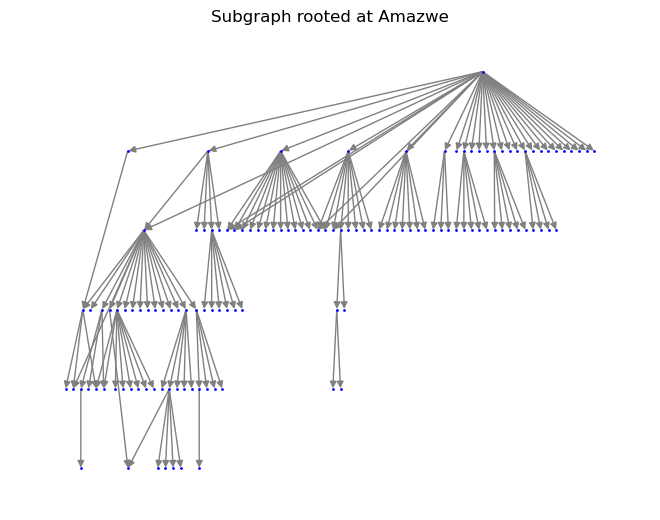

In [10]:
_ = get_and_plot_hierarchy_graph(dataset, cat_metadata, root="Amazwe")

# Checking that our documents have reasonable lengths

In [11]:
def count_words(entry):
    return len(entry["text"].split())


unordered_list_of_word_counts = [count_words(entry) for entry in dataset.data]
words_per_entry = sorted(unordered_list_of_word_counts)
word_count_df = pd.DataFrame(words_per_entry, columns=["word count"])
word_count_df.describe()

,word count
count,10065.000000
mean,37.076006
std,131.524043
min,1.000000
25%,8.000000
50%,10.000000
75%,21.000000
max,4155.000000


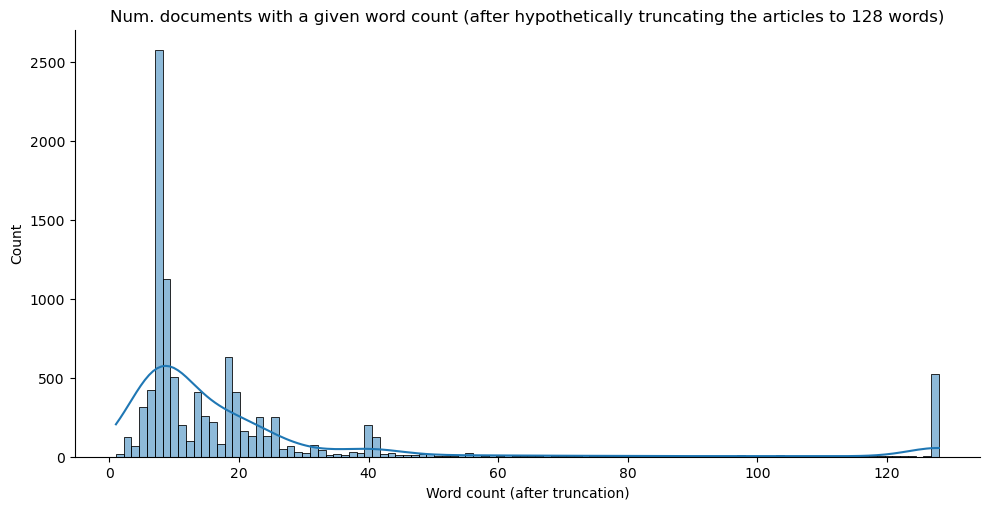

In [12]:
# For this plot, we assume our models will be limited to 128 tokens (and that every word is mapped to a single token, which is unlikely)
# Note that the documents in our dataset are not actually truncated to 128 tokens.
# However, they will most likely be truncated to 128 tokens during training.
max_seq_len = 128

word_count_df["Word count (after truncation)"] = word_count_df["word count"].apply(
    lambda x: min(x, max_seq_len)
)
sns.displot(
    word_count_df, x="Word count (after truncation)", kind="hist", kde=True, height=5, aspect=2
)
plt.title("Num. documents with a given word count (after hypothetically truncating the articles to 128 words)")
plt.show()

## Sanity checks / simple fuzz-tests

In [13]:
index_of_article_with_most_words = np.argmax(unordered_list_of_word_counts)
article_with_most_words = dataset.data[index_of_article_with_most_words]
print(f'Title: {article_with_most_words["title"]}')
print(f"Number of words: {count_words(article_with_most_words)}")

Title: Ukuvukela kweNtsha kwama-16 uNhlangulana we-1976
Number of words: 4155


For convenience, here is a link to the page: [https://zu.wikipedia.org/wiki/Ukuvukela_kweNtsha_kwama-16_uNhlangulana_we-1976](https://zu.wikipedia.org/wiki/Ukuvukela_kweNtsha_kwama-16_uNhlangulana_we-1976)

In [14]:
index_of_article_with_least_words = np.argmin(unordered_list_of_word_counts)
article_with_least_words = dataset.data[index_of_article_with_least_words]
print(f'Title: {article_with_least_words["title"]}\nText: {article_with_least_words["text"]}')
print(f"Number of words: {count_words(article_with_least_words)}")

Title: Mdlani
Text: Mdlani
Number of words: 1


For convenience: [https://zu.wikipedia.org/wiki/Mdlani](https://zu.wikipedia.org/wiki/Mdlani).

The page for "Mdlani" is a placeholder for a page that has not yet been written (i.e. this page is a "stub"), which is why it only contains one word.

# Final notes

1. We excluded the pages that list the subcategories of a category (i.e. the pages in the category namespace, such as [https://zu.wikipedia.org/wiki/Category:Amakhosi_akwaZulu](https://zu.wikipedia.org/wiki/Category:Amakhosi_akwaZulu)) from our dataset.
2. Some categories redirect to other categories (e.g. "Amazwe_eAfrika" redirects to "Amazwe_e-Afrika"). To handle this, we replaced all categories that are redirected with the categories they redirect to, so, articles labelled with "Amazwe_eAfrika" are labelled with "Amazwe_e-Afrika" in our dataset. 